In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


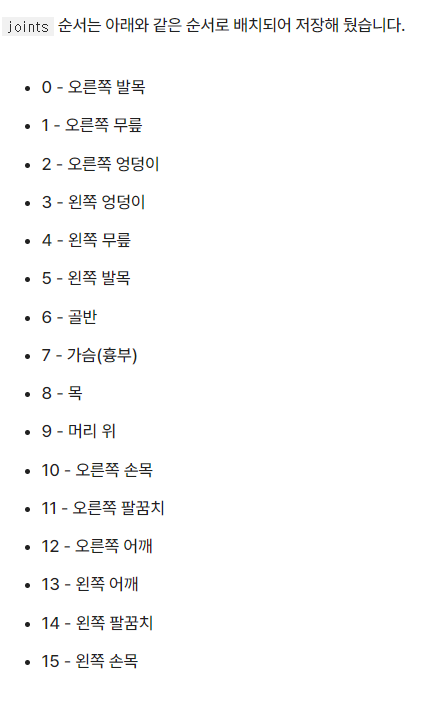

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=100)# 95 -> 100
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))


In [6]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [7]:
test_chunks = chunkify([0] * 1000, 64) # 함수 테스트
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [10]:
if False:
    num_train_shards = 72
    num_val_shards = 8

    ray.init()

    print('Start to parse annotations.')
    if not os.path.exists(TFRECORD_PATH):
        os.makedirs(TFRECORD_PATH)

    with open(TRAIN_JSON) as train_json:
        train_annos = json.load(train_json)
        train_annotations = [
            parse_one_annotation(anno, IMAGE_PATH)
            for anno in train_annos
        ]
        print('First train annotation: ', train_annotations[0])

    with open(VALID_JSON) as val_json:
        val_annos = json.load(val_json)
        val_annotations = [
            parse_one_annotation(anno, IMAGE_PATH) 
            for anno in val_annos
        ]
        print('First val annotation: ', val_annotations[0])

    print('Start to build TF Records.')
    build_tf_records(train_annotations, num_train_shards, 'train')
    build_tf_records(val_annotations, num_val_shards, 'val')

    print('Successfully wrote {} annotations to TF Records.'.format(
        len(train_annotations) + len(val_annotations)))

- 진행사항
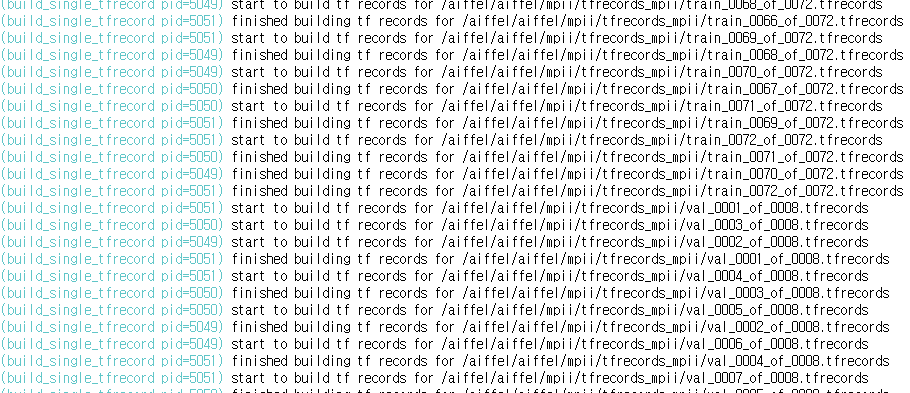

In [11]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0

        # keypoint 중 유효한값(visible = 1) 만 사용합니다.
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

        # min, max 값을 찾습니다.
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)

        # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

        # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]

        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

        return image, effective_keypoint_x, effective_keypoint_y

    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)


In [12]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x


In [13]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [14]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x


In [15]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

> Simplebaseline 모델

``` python
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
```

``` python
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model
```

``` python
upconv = _make_deconv_layer(3)
```

``` python
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')# 16 -> num_heatmap
```

``` python
def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model
```

위에 코드와 아래 코드의 차이를 모르겠지만, tensorflow의 버그로 인해 아래와 같은 오류가 나는것 같습니다. 그래서 아래와 같이 수정하였습니다.

In [16]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [17]:
def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')(inputs)
    x = _make_deconv_layer(3)(x)
    out = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

## 학습하기

In [18]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate,
                netname):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None
        self.netname = netname

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

#     def compute_loss(self, labels, outputs):
#         loss = 0
#         weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
#         for output in outputs:
           
#             loss += tf.math.reduce_mean(
#                 tf.math.square(labels - output) * weights) * (
#                     1. / self.global_batch_size)
#         return loss
    
#     def compute_loss(self, labels, outputs):
#         loss = 0
#         weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
#         labels_float32 = tf.cast(labels, dtype=tf.float32)  # Cast labels to float32
#         for output in outputs:
#             loss += tf.math.reduce_mean(tf.math.square(labels_float32 - output) * weights) * (1. / self.global_batch_size)
#         return loss

# ADD에서 float int 형 오류로 인하여 아래와 같이 수정
    def compute_loss(self, labels, outputs):
        loss = 0
        weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
        if self.netname == 'Simplebaseline':
            loss = tf.math.reduce_mean(
                tf.math.square(labels - outputs) * weights) * (
                    1.0 / self.global_batch_size)
        else:
            for output in outputs:
                loss += tf.math.reduce_mean(
                    tf.math.square(labels - output) * weights) * (
                        1.0 / self.global_batch_size)
        return loss
    
    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss),end='\n', flush=True)

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss),end='\n', flush=True)

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss, self.netname)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss, netname):
        model_name = MODEL_PATH + '/model-{}-epoch-{}-loss-{:.4f}.h5'.format(netname, epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))


In [19]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


In [20]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5 # 10
batch_size = 22
num_heatmap = 16
learning_rate = 0.0007

- compute_loss 에러가 계속 발생하여 5 에폭으로 진행

In [22]:
# def Simplebaseline(input_shape=(256, 256, 3), num_heatmap=16):
#     inputs = tf.keras.Input(shape=input_shape)
    
    
#     # Using the ResNet-50 backbone
#     x = resnet(inputs)
    
    
    
    
#     # Applying the upconvolution layers
#     x = upconv(x)

#     # Final layer to predict heatmaps
#     out = final_layer(x)

#     model = tf.keras.Model(inputs, out, name='simple_baseline')
#     return model
simplebaselineModel = Simplebaseline()
simplebaselineModel.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [23]:
np_input = np.zeros((1,256,256,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = simplebaselineModel(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output[0,:10,:10,:10])

input shape
(1, 256, 256, 3)


output shape
(1, 64, 64, 16)
tf.Tensor(
[[[-5.75438782e-04  1.12371170e-03  1.89074932e-03  6.89952821e-03
    1.07684545e-03 -5.05364500e-03 -1.44692315e-02 -4.77187242e-03
    1.13513111e-03  9.61332954e-03]
  [-7.49073504e-03  4.88342531e-03  3.51488078e-03 -1.27838936e-03
    3.81092750e-03  3.53775825e-03 -1.92286689e-02  6.57946570e-04
    7.78276287e-03  1.56998225e-02]
  [-3.34744272e-03  1.37133300e-02  4.72514518e-03  2.90615414e-03
    9.07373556e-04 -2.47069006e-03 -7.58579187e-03 -7.96888210e-03
    1.23360055e-03  1.54836457e-02]
  [-9.59786586e-04 -7.69795896e-03  1.09205358e-02  3.53340758e-03
    6.35259878e-03  1.03133395e-02 -1.74474921e-02  1.25047704e-02
   -1.24712326e-02 -9.59752244e-04]
  [-7.53841037e-03  9.31463391e-03  5.03932266e-03  1.86255632e-03
    6.72540627e-03 -2.05353927e-02 -1.23824114e-02 -2.09206827e-02
   -8.89463164e-03 -3.63498414e-03]
  [-1.08138248e-02 -6.33261225e-04 -3.01773334e-03  5.02392231e-03
    8.726300

In [24]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, is_single=False):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)
        if is_single:
            model = Simplebaseline(IMAGE_SHAPE)
            netname='Simplebaseline'
        else:
            model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)
            netname='StackedHourglass'
            
        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate,
        netname=netname)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)


In [28]:


# best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, is_single=False)
best_model_file = MODEL_PATH + '/model-StackedHourglass-epoch-5-loss-0.8700.h5'

- 오류 해결하다가 학습결과를 잃어버렸다......
- best_model_file 학습 결과는 아래와 같다 5에폭 결과로 같은 추론을 진행 
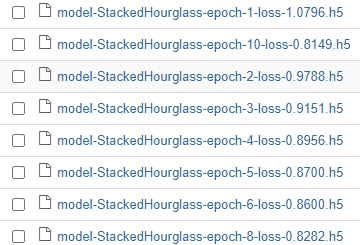

In [26]:
#Simplebaseline 으로 학습
best_simple_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords, is_single=True)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 0.452406019 epoch total loss 0.452406019
Trained batch 2 batch loss 0.456843793 epoch total loss 0.454624891
Trained batch 3 batch loss 0.394531161 epoch total loss 0.434593648
Trained batch 4 batch loss 0.37716195 epoch total loss 0.420235723
Trained batch 5 batch loss 0.355460554 epoch total loss 0.407280684
Trained batch 6 batch loss 0.357482523 epoch total loss 0.398980975
Trained batch 7 batch loss 0.349429756 epoch total loss 0.391902238
Trained batch 8 batch loss 0.322359592 epoch total loss 0.383209407
Trained batch 9 batch loss 0.294748276 epoch total loss 0.373380393
Trained batch 10 batch loss 0.269392401 epoch total loss 0.362981617
Trained batch 11 batch loss 0.257674456 epoch total loss 0.353408217
Trained batch 12 batch loss 0.286739826 epoch total loss 0.347852558
Trained batch 13 batch loss 0.280446053 epoch total loss 0.342667431
Trained batch 14 batch loss 0.302086651 epoch total loss 0.339768827
Trained batch

Trained batch 120 batch loss 0.256198406 epoch total loss 0.284959108
Trained batch 121 batch loss 0.272969306 epoch total loss 0.28486
Trained batch 122 batch loss 0.277787685 epoch total loss 0.28480202
Trained batch 123 batch loss 0.26717335 epoch total loss 0.2846587
Trained batch 124 batch loss 0.256566048 epoch total loss 0.284432143
Trained batch 125 batch loss 0.261952579 epoch total loss 0.284252286
Trained batch 126 batch loss 0.256215721 epoch total loss 0.284029752
Trained batch 127 batch loss 0.242974401 epoch total loss 0.283706486
Trained batch 128 batch loss 0.237971961 epoch total loss 0.283349186
Trained batch 129 batch loss 0.232611448 epoch total loss 0.282955885
Trained batch 130 batch loss 0.219777271 epoch total loss 0.282469869
Trained batch 131 batch loss 0.213662282 epoch total loss 0.281944633
Trained batch 132 batch loss 0.255518228 epoch total loss 0.28174445
Trained batch 133 batch loss 0.283774436 epoch total loss 0.281759709
Trained batch 134 batch loss 

Trained batch 238 batch loss 0.243414849 epoch total loss 0.271504223
Trained batch 239 batch loss 0.237050578 epoch total loss 0.27136007
Trained batch 240 batch loss 0.246405482 epoch total loss 0.271256089
Trained batch 241 batch loss 0.254008234 epoch total loss 0.271184504
Trained batch 242 batch loss 0.259410173 epoch total loss 0.271135837
Trained batch 243 batch loss 0.246457472 epoch total loss 0.2710343
Trained batch 244 batch loss 0.240067244 epoch total loss 0.270907372
Trained batch 245 batch loss 0.241491526 epoch total loss 0.270787328
Trained batch 246 batch loss 0.233911008 epoch total loss 0.270637423
Trained batch 247 batch loss 0.231592223 epoch total loss 0.270479321
Trained batch 248 batch loss 0.241915911 epoch total loss 0.270364136
Trained batch 249 batch loss 0.25264588 epoch total loss 0.270293
Trained batch 250 batch loss 0.25792709 epoch total loss 0.270243526
Trained batch 251 batch loss 0.251806468 epoch total loss 0.270170093
Trained batch 252 batch loss

Trained batch 356 batch loss 0.256934434 epoch total loss 0.265007883
Trained batch 357 batch loss 0.263482958 epoch total loss 0.265003622
Trained batch 358 batch loss 0.247001916 epoch total loss 0.264953345
Trained batch 359 batch loss 0.246942326 epoch total loss 0.264903158
Trained batch 360 batch loss 0.245948792 epoch total loss 0.264850497
Trained batch 361 batch loss 0.240805864 epoch total loss 0.264783919
Trained batch 362 batch loss 0.251034081 epoch total loss 0.264745921
Trained batch 363 batch loss 0.237247542 epoch total loss 0.264670193
Trained batch 364 batch loss 0.233490989 epoch total loss 0.264584541
Trained batch 365 batch loss 0.240414515 epoch total loss 0.264518321
Trained batch 366 batch loss 0.253288478 epoch total loss 0.264487624
Trained batch 367 batch loss 0.252171546 epoch total loss 0.264454097
Trained batch 368 batch loss 0.242875889 epoch total loss 0.264395446
Trained batch 369 batch loss 0.221324608 epoch total loss 0.26427871
Trained batch 370 bat

Trained batch 474 batch loss 0.253063709 epoch total loss 0.260135651
Trained batch 475 batch loss 0.247643232 epoch total loss 0.260109335
Trained batch 476 batch loss 0.237382218 epoch total loss 0.260061592
Trained batch 477 batch loss 0.236737296 epoch total loss 0.260012716
Trained batch 478 batch loss 0.262708962 epoch total loss 0.260018349
Trained batch 479 batch loss 0.241451591 epoch total loss 0.259979606
Trained batch 480 batch loss 0.252655536 epoch total loss 0.259964347
Trained batch 481 batch loss 0.22255294 epoch total loss 0.259886563
Trained batch 482 batch loss 0.225339353 epoch total loss 0.259814888
Trained batch 483 batch loss 0.228704914 epoch total loss 0.259750485
Trained batch 484 batch loss 0.244647831 epoch total loss 0.259719253
Trained batch 485 batch loss 0.248808429 epoch total loss 0.259696782
Trained batch 486 batch loss 0.258382678 epoch total loss 0.25969407
Trained batch 487 batch loss 0.219235837 epoch total loss 0.259611
Trained batch 488 batch l

Trained batch 592 batch loss 0.243074685 epoch total loss 0.256871879
Trained batch 593 batch loss 0.258796394 epoch total loss 0.256875128
Trained batch 594 batch loss 0.236611128 epoch total loss 0.256841034
Trained batch 595 batch loss 0.244393095 epoch total loss 0.256820112
Trained batch 596 batch loss 0.2407915 epoch total loss 0.256793231
Trained batch 597 batch loss 0.243932933 epoch total loss 0.256771684
Trained batch 598 batch loss 0.220020801 epoch total loss 0.256710231
Trained batch 599 batch loss 0.223983094 epoch total loss 0.256655574
Trained batch 600 batch loss 0.20110245 epoch total loss 0.256562978
Trained batch 601 batch loss 0.230607033 epoch total loss 0.256519794
Trained batch 602 batch loss 0.249452516 epoch total loss 0.256508052
Trained batch 603 batch loss 0.25091 epoch total loss 0.256498784
Trained batch 604 batch loss 0.279472619 epoch total loss 0.256536812
Trained batch 605 batch loss 0.243102774 epoch total loss 0.256514609
Trained batch 606 batch los

Trained batch 710 batch loss 0.223396853 epoch total loss 0.253630728
Trained batch 711 batch loss 0.221473247 epoch total loss 0.253585488
Trained batch 712 batch loss 0.22083509 epoch total loss 0.253539503
Trained batch 713 batch loss 0.225028932 epoch total loss 0.253499508
Trained batch 714 batch loss 0.22341074 epoch total loss 0.253457367
Trained batch 715 batch loss 0.234283924 epoch total loss 0.253430545
Trained batch 716 batch loss 0.212042987 epoch total loss 0.253372729
Trained batch 717 batch loss 0.197840527 epoch total loss 0.253295273
Trained batch 718 batch loss 0.215974271 epoch total loss 0.253243297
Trained batch 719 batch loss 0.201099902 epoch total loss 0.253170758
Trained batch 720 batch loss 0.2085931 epoch total loss 0.253108859
Trained batch 721 batch loss 0.225883842 epoch total loss 0.2530711
Trained batch 722 batch loss 0.226056516 epoch total loss 0.253033698
Trained batch 723 batch loss 0.228570923 epoch total loss 0.252999872
Trained batch 724 batch lo

Trained batch 828 batch loss 0.248348 epoch total loss 0.250897586
Trained batch 829 batch loss 0.240221009 epoch total loss 0.250884712
Trained batch 830 batch loss 0.230468407 epoch total loss 0.250860125
Trained batch 831 batch loss 0.226427 epoch total loss 0.25083071
Trained batch 832 batch loss 0.224832907 epoch total loss 0.250799477
Trained batch 833 batch loss 0.231378824 epoch total loss 0.250776172
Trained batch 834 batch loss 0.223687097 epoch total loss 0.250743687
Trained batch 835 batch loss 0.228293493 epoch total loss 0.250716805
Trained batch 836 batch loss 0.239190564 epoch total loss 0.250703
Trained batch 837 batch loss 0.234496 epoch total loss 0.250683665
Trained batch 838 batch loss 0.223396465 epoch total loss 0.250651091
Trained batch 839 batch loss 0.246911705 epoch total loss 0.250646651
Trained batch 840 batch loss 0.258137643 epoch total loss 0.250655562
Trained batch 841 batch loss 0.262322664 epoch total loss 0.25066945
Trained batch 842 batch loss 0.230

Trained batch 946 batch loss 0.201756895 epoch total loss 0.248464659
Trained batch 947 batch loss 0.225928247 epoch total loss 0.248440847
Trained batch 948 batch loss 0.275129527 epoch total loss 0.24846901
Trained batch 949 batch loss 0.253826857 epoch total loss 0.248474658
Trained batch 950 batch loss 0.217423245 epoch total loss 0.248441964
Trained batch 951 batch loss 0.226532623 epoch total loss 0.248418927
Trained batch 952 batch loss 0.22681655 epoch total loss 0.248396248
Trained batch 953 batch loss 0.226347923 epoch total loss 0.248373106
Trained batch 954 batch loss 0.250684083 epoch total loss 0.248375535
Trained batch 955 batch loss 0.221642852 epoch total loss 0.248347551
Trained batch 956 batch loss 0.23715429 epoch total loss 0.248335838
Trained batch 957 batch loss 0.220582619 epoch total loss 0.248306826
Trained batch 958 batch loss 0.219857499 epoch total loss 0.248277143
Trained batch 959 batch loss 0.242267251 epoch total loss 0.248270869
Trained batch 960 batch

Validated batch 91 batch loss 0.240715116
Validated batch 92 batch loss 0.228844568
Validated batch 93 batch loss 0.211990356
Validated batch 94 batch loss 0.24160026
Validated batch 95 batch loss 0.248741418
Validated batch 96 batch loss 0.230648369
Validated batch 97 batch loss 0.239045307
Validated batch 98 batch loss 0.206928968
Validated batch 99 batch loss 0.217553839
Validated batch 100 batch loss 0.241293758
Validated batch 101 batch loss 0.246166587
Validated batch 102 batch loss 0.251300961
Validated batch 103 batch loss 0.231526211
Validated batch 104 batch loss 0.22342065
Validated batch 105 batch loss 0.228674814
Validated batch 106 batch loss 0.224182695
Validated batch 107 batch loss 0.229212463
Validated batch 108 batch loss 0.252884448
Validated batch 109 batch loss 0.212603793
Validated batch 110 batch loss 0.232508838
Validated batch 111 batch loss 0.233807504
Validated batch 112 batch loss 0.259382874
Validated batch 113 batch loss 0.234008729
Validated batch 114 ba

Trained batch 90 batch loss 0.232213289 epoch total loss 0.227330104
Trained batch 91 batch loss 0.2218941 epoch total loss 0.22727035
Trained batch 92 batch loss 0.219396561 epoch total loss 0.227184772
Trained batch 93 batch loss 0.247281402 epoch total loss 0.227400869
Trained batch 94 batch loss 0.24337019 epoch total loss 0.227570757
Trained batch 95 batch loss 0.207419768 epoch total loss 0.227358654
Trained batch 96 batch loss 0.211078912 epoch total loss 0.227189064
Trained batch 97 batch loss 0.219984174 epoch total loss 0.227114782
Trained batch 98 batch loss 0.24795267 epoch total loss 0.227327421
Trained batch 99 batch loss 0.213315293 epoch total loss 0.22718589
Trained batch 100 batch loss 0.227699518 epoch total loss 0.227191031
Trained batch 101 batch loss 0.220524773 epoch total loss 0.227125019
Trained batch 102 batch loss 0.21258232 epoch total loss 0.22698243
Trained batch 103 batch loss 0.228992015 epoch total loss 0.22700195
Trained batch 104 batch loss 0.22261552

Trained batch 208 batch loss 0.211961195 epoch total loss 0.22715047
Trained batch 209 batch loss 0.205060706 epoch total loss 0.227044776
Trained batch 210 batch loss 0.225530848 epoch total loss 0.227037579
Trained batch 211 batch loss 0.248804539 epoch total loss 0.22714074
Trained batch 212 batch loss 0.229430959 epoch total loss 0.227151543
Trained batch 213 batch loss 0.245650411 epoch total loss 0.227238402
Trained batch 214 batch loss 0.265281945 epoch total loss 0.227416173
Trained batch 215 batch loss 0.219786718 epoch total loss 0.227380693
Trained batch 216 batch loss 0.204420701 epoch total loss 0.227274403
Trained batch 217 batch loss 0.190655157 epoch total loss 0.227105647
Trained batch 218 batch loss 0.205502063 epoch total loss 0.22700654
Trained batch 219 batch loss 0.173415408 epoch total loss 0.226761833
Trained batch 220 batch loss 0.175937325 epoch total loss 0.22653082
Trained batch 221 batch loss 0.194527432 epoch total loss 0.226386011
Trained batch 222 batch 

Trained batch 326 batch loss 0.232924789 epoch total loss 0.225956857
Trained batch 327 batch loss 0.23345159 epoch total loss 0.225979775
Trained batch 328 batch loss 0.215520561 epoch total loss 0.225947887
Trained batch 329 batch loss 0.211699754 epoch total loss 0.225904584
Trained batch 330 batch loss 0.218881026 epoch total loss 0.225883305
Trained batch 331 batch loss 0.236422092 epoch total loss 0.225915134
Trained batch 332 batch loss 0.222736254 epoch total loss 0.225905538
Trained batch 333 batch loss 0.226007447 epoch total loss 0.225905851
Trained batch 334 batch loss 0.195531175 epoch total loss 0.225814909
Trained batch 335 batch loss 0.222248212 epoch total loss 0.225804269
Trained batch 336 batch loss 0.22731027 epoch total loss 0.225808755
Trained batch 337 batch loss 0.243471131 epoch total loss 0.225861162
Trained batch 338 batch loss 0.223802656 epoch total loss 0.225855067
Trained batch 339 batch loss 0.225693837 epoch total loss 0.225854591
Trained batch 340 batc

Trained batch 444 batch loss 0.217101187 epoch total loss 0.225476
Trained batch 445 batch loss 0.231454253 epoch total loss 0.225489423
Trained batch 446 batch loss 0.222954839 epoch total loss 0.225483745
Trained batch 447 batch loss 0.218961507 epoch total loss 0.225469157
Trained batch 448 batch loss 0.217640534 epoch total loss 0.225451693
Trained batch 449 batch loss 0.198974743 epoch total loss 0.225392729
Trained batch 450 batch loss 0.231733769 epoch total loss 0.225406811
Trained batch 451 batch loss 0.251180559 epoch total loss 0.225463971
Trained batch 452 batch loss 0.249099851 epoch total loss 0.22551626
Trained batch 453 batch loss 0.231932089 epoch total loss 0.225530431
Trained batch 454 batch loss 0.206732839 epoch total loss 0.22548902
Trained batch 455 batch loss 0.210626587 epoch total loss 0.225456357
Trained batch 456 batch loss 0.228419766 epoch total loss 0.225462854
Trained batch 457 batch loss 0.225852892 epoch total loss 0.225463703
Trained batch 458 batch l

Trained batch 562 batch loss 0.239787817 epoch total loss 0.224603742
Trained batch 563 batch loss 0.251615196 epoch total loss 0.224651724
Trained batch 564 batch loss 0.240615353 epoch total loss 0.224680021
Trained batch 565 batch loss 0.235095203 epoch total loss 0.224698454
Trained batch 566 batch loss 0.203958839 epoch total loss 0.224661812
Trained batch 567 batch loss 0.214915037 epoch total loss 0.224644616
Trained batch 568 batch loss 0.207051367 epoch total loss 0.224613652
Trained batch 569 batch loss 0.225183859 epoch total loss 0.22461465
Trained batch 570 batch loss 0.229434 epoch total loss 0.224623114
Trained batch 571 batch loss 0.229675084 epoch total loss 0.22463195
Trained batch 572 batch loss 0.2480077 epoch total loss 0.224672809
Trained batch 573 batch loss 0.230326593 epoch total loss 0.224682689
Trained batch 574 batch loss 0.229435757 epoch total loss 0.224690959
Trained batch 575 batch loss 0.211714119 epoch total loss 0.224668398
Trained batch 576 batch los

Trained batch 680 batch loss 0.225854561 epoch total loss 0.224480122
Trained batch 681 batch loss 0.238013789 epoch total loss 0.224499986
Trained batch 682 batch loss 0.216936707 epoch total loss 0.224488899
Trained batch 683 batch loss 0.211760879 epoch total loss 0.224470258
Trained batch 684 batch loss 0.214738056 epoch total loss 0.224456027
Trained batch 685 batch loss 0.211352184 epoch total loss 0.224436894
Trained batch 686 batch loss 0.219382644 epoch total loss 0.224429518
Trained batch 687 batch loss 0.225162596 epoch total loss 0.224430576
Trained batch 688 batch loss 0.2209391 epoch total loss 0.224425495
Trained batch 689 batch loss 0.208028734 epoch total loss 0.224401683
Trained batch 690 batch loss 0.219479114 epoch total loss 0.22439456
Trained batch 691 batch loss 0.228121608 epoch total loss 0.224399954
Trained batch 692 batch loss 0.23268804 epoch total loss 0.22441192
Trained batch 693 batch loss 0.211153343 epoch total loss 0.224392787
Trained batch 694 batch l

Trained batch 798 batch loss 0.226289257 epoch total loss 0.224240914
Trained batch 799 batch loss 0.218872488 epoch total loss 0.224234194
Trained batch 800 batch loss 0.229474247 epoch total loss 0.224240735
Trained batch 801 batch loss 0.223225489 epoch total loss 0.224239469
Trained batch 802 batch loss 0.228384241 epoch total loss 0.224244624
Trained batch 803 batch loss 0.240242183 epoch total loss 0.224264562
Trained batch 804 batch loss 0.247521803 epoch total loss 0.2242935
Trained batch 805 batch loss 0.24707073 epoch total loss 0.224321783
Trained batch 806 batch loss 0.2465083 epoch total loss 0.22434932
Trained batch 807 batch loss 0.242128059 epoch total loss 0.224371344
Trained batch 808 batch loss 0.243819326 epoch total loss 0.224395409
Trained batch 809 batch loss 0.235484481 epoch total loss 0.224409118
Trained batch 810 batch loss 0.230900466 epoch total loss 0.224417135
Trained batch 811 batch loss 0.236035869 epoch total loss 0.224431455
Trained batch 812 batch lo

Trained batch 916 batch loss 0.204013288 epoch total loss 0.223860532
Trained batch 917 batch loss 0.200315908 epoch total loss 0.223834857
Trained batch 918 batch loss 0.232391626 epoch total loss 0.223844171
Trained batch 919 batch loss 0.213710397 epoch total loss 0.223833159
Trained batch 920 batch loss 0.213007927 epoch total loss 0.223821387
Trained batch 921 batch loss 0.206932589 epoch total loss 0.223803058
Trained batch 922 batch loss 0.21343492 epoch total loss 0.223791823
Trained batch 923 batch loss 0.206438437 epoch total loss 0.223773018
Trained batch 924 batch loss 0.202416077 epoch total loss 0.223749906
Trained batch 925 batch loss 0.230634779 epoch total loss 0.223757356
Trained batch 926 batch loss 0.235276401 epoch total loss 0.223769799
Trained batch 927 batch loss 0.227344587 epoch total loss 0.223773643
Trained batch 928 batch loss 0.223805949 epoch total loss 0.223773673
Trained batch 929 batch loss 0.20195058 epoch total loss 0.223750189
Trained batch 930 batc

Validated batch 42 batch loss 0.219139606
Validated batch 43 batch loss 0.211123884
Validated batch 44 batch loss 0.219273418
Validated batch 45 batch loss 0.213341832
Validated batch 46 batch loss 0.236475065
Validated batch 47 batch loss 0.223669142
Validated batch 48 batch loss 0.218023479
Validated batch 49 batch loss 0.220502585
Validated batch 50 batch loss 0.205178827
Validated batch 51 batch loss 0.230923101
Validated batch 52 batch loss 0.208349392
Validated batch 53 batch loss 0.226085752
Validated batch 54 batch loss 0.214190692
Validated batch 55 batch loss 0.236729518
Validated batch 56 batch loss 0.212716088
Validated batch 57 batch loss 0.230273455
Validated batch 58 batch loss 0.214369461
Validated batch 59 batch loss 0.196358621
Validated batch 60 batch loss 0.216771394
Validated batch 61 batch loss 0.239481971
Validated batch 62 batch loss 0.242343187
Validated batch 63 batch loss 0.232020944
Validated batch 64 batch loss 0.223922148
Validated batch 65 batch loss 0.22

Trained batch 60 batch loss 0.180753231 epoch total loss 0.212697923
Trained batch 61 batch loss 0.178727344 epoch total loss 0.212141022
Trained batch 62 batch loss 0.200280458 epoch total loss 0.211949721
Trained batch 63 batch loss 0.175294176 epoch total loss 0.211367875
Trained batch 64 batch loss 0.19717364 epoch total loss 0.211146101
Trained batch 65 batch loss 0.19143495 epoch total loss 0.210842848
Trained batch 66 batch loss 0.230283186 epoch total loss 0.211137399
Trained batch 67 batch loss 0.207909763 epoch total loss 0.211089224
Trained batch 68 batch loss 0.236100554 epoch total loss 0.211457029
Trained batch 69 batch loss 0.190135941 epoch total loss 0.211148024
Trained batch 70 batch loss 0.198682472 epoch total loss 0.210969955
Trained batch 71 batch loss 0.202261582 epoch total loss 0.210847303
Trained batch 72 batch loss 0.217415467 epoch total loss 0.210938528
Trained batch 73 batch loss 0.220908687 epoch total loss 0.211075112
Trained batch 74 batch loss 0.226411

Trained batch 179 batch loss 0.235289469 epoch total loss 0.2111734
Trained batch 180 batch loss 0.226874992 epoch total loss 0.211260632
Trained batch 181 batch loss 0.247968271 epoch total loss 0.211463422
Trained batch 182 batch loss 0.214554518 epoch total loss 0.211480409
Trained batch 183 batch loss 0.21074751 epoch total loss 0.2114764
Trained batch 184 batch loss 0.232392624 epoch total loss 0.211590067
Trained batch 185 batch loss 0.220691666 epoch total loss 0.211639255
Trained batch 186 batch loss 0.201251388 epoch total loss 0.211583421
Trained batch 187 batch loss 0.176842391 epoch total loss 0.211397633
Trained batch 188 batch loss 0.171029463 epoch total loss 0.211182892
Trained batch 189 batch loss 0.190184072 epoch total loss 0.211071804
Trained batch 190 batch loss 0.182434246 epoch total loss 0.210921079
Trained batch 191 batch loss 0.199823335 epoch total loss 0.210862964
Trained batch 192 batch loss 0.184648365 epoch total loss 0.210726425
Trained batch 193 batch l

Trained batch 297 batch loss 0.234084398 epoch total loss 0.213942319
Trained batch 298 batch loss 0.263842523 epoch total loss 0.214109778
Trained batch 299 batch loss 0.243566751 epoch total loss 0.21420829
Trained batch 300 batch loss 0.225527316 epoch total loss 0.21424602
Trained batch 301 batch loss 0.220228076 epoch total loss 0.214265898
Trained batch 302 batch loss 0.201286346 epoch total loss 0.214222908
Trained batch 303 batch loss 0.216628715 epoch total loss 0.21423085
Trained batch 304 batch loss 0.225332826 epoch total loss 0.214267373
Trained batch 305 batch loss 0.209537193 epoch total loss 0.214251861
Trained batch 306 batch loss 0.204635844 epoch total loss 0.214220434
Trained batch 307 batch loss 0.198215336 epoch total loss 0.21416828
Trained batch 308 batch loss 0.198273316 epoch total loss 0.214116678
Trained batch 309 batch loss 0.20740518 epoch total loss 0.214094952
Trained batch 310 batch loss 0.204210445 epoch total loss 0.214063063
Trained batch 311 batch l

Trained batch 415 batch loss 0.220194191 epoch total loss 0.21351707
Trained batch 416 batch loss 0.233815283 epoch total loss 0.213565856
Trained batch 417 batch loss 0.213792771 epoch total loss 0.213566408
Trained batch 418 batch loss 0.188519284 epoch total loss 0.21350649
Trained batch 419 batch loss 0.196009636 epoch total loss 0.213464722
Trained batch 420 batch loss 0.197789907 epoch total loss 0.21342741
Trained batch 421 batch loss 0.201619267 epoch total loss 0.213399366
Trained batch 422 batch loss 0.216189265 epoch total loss 0.213405967
Trained batch 423 batch loss 0.207203522 epoch total loss 0.213391319
Trained batch 424 batch loss 0.228904665 epoch total loss 0.213427901
Trained batch 425 batch loss 0.231482863 epoch total loss 0.213470384
Trained batch 426 batch loss 0.209963977 epoch total loss 0.213462144
Trained batch 427 batch loss 0.219513446 epoch total loss 0.213476315
Trained batch 428 batch loss 0.226057902 epoch total loss 0.213505715
Trained batch 429 batch

Trained batch 533 batch loss 0.207486987 epoch total loss 0.214329422
Trained batch 534 batch loss 0.226743922 epoch total loss 0.214352667
Trained batch 535 batch loss 0.212886497 epoch total loss 0.214349926
Trained batch 536 batch loss 0.204823658 epoch total loss 0.214332148
Trained batch 537 batch loss 0.211869597 epoch total loss 0.214327559
Trained batch 538 batch loss 0.206508622 epoch total loss 0.21431303
Trained batch 539 batch loss 0.22620289 epoch total loss 0.214335084
Trained batch 540 batch loss 0.189213753 epoch total loss 0.214288577
Trained batch 541 batch loss 0.227803916 epoch total loss 0.214313552
Trained batch 542 batch loss 0.211947888 epoch total loss 0.214309186
Trained batch 543 batch loss 0.229775801 epoch total loss 0.214337662
Trained batch 544 batch loss 0.220650747 epoch total loss 0.21434927
Trained batch 545 batch loss 0.237795919 epoch total loss 0.21439229
Trained batch 546 batch loss 0.194331154 epoch total loss 0.214355543
Trained batch 547 batch 

Trained batch 651 batch loss 0.214352459 epoch total loss 0.214252859
Trained batch 652 batch loss 0.213232741 epoch total loss 0.21425128
Trained batch 653 batch loss 0.203534365 epoch total loss 0.214234874
Trained batch 654 batch loss 0.20430468 epoch total loss 0.214219674
Trained batch 655 batch loss 0.241984367 epoch total loss 0.214262068
Trained batch 656 batch loss 0.223276883 epoch total loss 0.214275822
Trained batch 657 batch loss 0.222653598 epoch total loss 0.214288577
Trained batch 658 batch loss 0.199275389 epoch total loss 0.214265764
Trained batch 659 batch loss 0.197037637 epoch total loss 0.214239627
Trained batch 660 batch loss 0.226059124 epoch total loss 0.214257538
Trained batch 661 batch loss 0.225729927 epoch total loss 0.214274883
Trained batch 662 batch loss 0.229551718 epoch total loss 0.214297965
Trained batch 663 batch loss 0.234370559 epoch total loss 0.214328244
Trained batch 664 batch loss 0.235662147 epoch total loss 0.214360356
Trained batch 665 batc

Trained batch 769 batch loss 0.22423996 epoch total loss 0.214426309
Trained batch 770 batch loss 0.221964821 epoch total loss 0.214436099
Trained batch 771 batch loss 0.244597569 epoch total loss 0.214475229
Trained batch 772 batch loss 0.230415568 epoch total loss 0.214495882
Trained batch 773 batch loss 0.230559707 epoch total loss 0.21451667
Trained batch 774 batch loss 0.212216109 epoch total loss 0.214513689
Trained batch 775 batch loss 0.232242197 epoch total loss 0.214536563
Trained batch 776 batch loss 0.233920231 epoch total loss 0.214561537
Trained batch 777 batch loss 0.246499822 epoch total loss 0.214602649
Trained batch 778 batch loss 0.23258242 epoch total loss 0.214625776
Trained batch 779 batch loss 0.209495902 epoch total loss 0.214619204
Trained batch 780 batch loss 0.222864598 epoch total loss 0.214629769
Trained batch 781 batch loss 0.231349871 epoch total loss 0.214651182
Trained batch 782 batch loss 0.221445248 epoch total loss 0.214659885
Trained batch 783 batch

Trained batch 887 batch loss 0.221124917 epoch total loss 0.214144722
Trained batch 888 batch loss 0.229024395 epoch total loss 0.214161471
Trained batch 889 batch loss 0.214054957 epoch total loss 0.214161351
Trained batch 890 batch loss 0.21447739 epoch total loss 0.214161694
Trained batch 891 batch loss 0.228709906 epoch total loss 0.214178026
Trained batch 892 batch loss 0.206344634 epoch total loss 0.214169249
Trained batch 893 batch loss 0.194544032 epoch total loss 0.214147285
Trained batch 894 batch loss 0.179363847 epoch total loss 0.214108378
Trained batch 895 batch loss 0.197482347 epoch total loss 0.214089796
Trained batch 896 batch loss 0.230530098 epoch total loss 0.214108139
Trained batch 897 batch loss 0.216695204 epoch total loss 0.214111015
Trained batch 898 batch loss 0.225516245 epoch total loss 0.214123711
Trained batch 899 batch loss 0.21446313 epoch total loss 0.214124098
Trained batch 900 batch loss 0.205617741 epoch total loss 0.214114636
Trained batch 901 batc

Trained batch 1005 batch loss 0.232487604 epoch total loss 0.213873655
Trained batch 1006 batch loss 0.201111108 epoch total loss 0.213860974
Trained batch 1007 batch loss 0.202578351 epoch total loss 0.213849768
Trained batch 1008 batch loss 0.232897177 epoch total loss 0.213868663
Epoch 3 train loss 0.2138686627149582
Validated batch 1 batch loss 0.209692746
Validated batch 2 batch loss 0.20811145
Validated batch 3 batch loss 0.198003799
Validated batch 4 batch loss 0.222061709
Validated batch 5 batch loss 0.208889857
Validated batch 6 batch loss 0.189233974
Validated batch 7 batch loss 0.212349832
Validated batch 8 batch loss 0.198346943
Validated batch 9 batch loss 0.208083853
Validated batch 10 batch loss 0.213438675
Validated batch 11 batch loss 0.237294987
Validated batch 12 batch loss 0.217496276
Validated batch 13 batch loss 0.227336109
Validated batch 14 batch loss 0.187636212
Validated batch 15 batch loss 0.20894812
Validated batch 16 batch loss 0.218353018
Validated batch 1

Trained batch 31 batch loss 0.188945845 epoch total loss 0.196342275
Trained batch 32 batch loss 0.198554412 epoch total loss 0.196411401
Trained batch 33 batch loss 0.203508884 epoch total loss 0.196626469
Trained batch 34 batch loss 0.222644225 epoch total loss 0.197391704
Trained batch 35 batch loss 0.197481051 epoch total loss 0.197394267
Trained batch 36 batch loss 0.196376547 epoch total loss 0.197365984
Trained batch 37 batch loss 0.21043849 epoch total loss 0.197719291
Trained batch 38 batch loss 0.218115807 epoch total loss 0.198256046
Trained batch 39 batch loss 0.20529294 epoch total loss 0.198436469
Trained batch 40 batch loss 0.196340933 epoch total loss 0.198384076
Trained batch 41 batch loss 0.205352917 epoch total loss 0.198554069
Trained batch 42 batch loss 0.218592778 epoch total loss 0.199031174
Trained batch 43 batch loss 0.216027617 epoch total loss 0.199426427
Trained batch 44 batch loss 0.227822959 epoch total loss 0.200071812
Trained batch 45 batch loss 0.222514

Trained batch 150 batch loss 0.209269032 epoch total loss 0.204156086
Trained batch 151 batch loss 0.217242852 epoch total loss 0.204242751
Trained batch 152 batch loss 0.22500889 epoch total loss 0.204379365
Trained batch 153 batch loss 0.20622696 epoch total loss 0.204391435
Trained batch 154 batch loss 0.209778622 epoch total loss 0.204426423
Trained batch 155 batch loss 0.219851 epoch total loss 0.204525933
Trained batch 156 batch loss 0.219087675 epoch total loss 0.204619274
Trained batch 157 batch loss 0.220626011 epoch total loss 0.204721227
Trained batch 158 batch loss 0.223299071 epoch total loss 0.204838812
Trained batch 159 batch loss 0.225735977 epoch total loss 0.204970241
Trained batch 160 batch loss 0.216512039 epoch total loss 0.205042362
Trained batch 161 batch loss 0.19822602 epoch total loss 0.205000028
Trained batch 162 batch loss 0.177995488 epoch total loss 0.204833329
Trained batch 163 batch loss 0.187086284 epoch total loss 0.204724461
Trained batch 164 batch lo

Trained batch 268 batch loss 0.185314789 epoch total loss 0.203695431
Trained batch 269 batch loss 0.217581585 epoch total loss 0.203747049
Trained batch 270 batch loss 0.201664582 epoch total loss 0.20373933
Trained batch 271 batch loss 0.205487728 epoch total loss 0.203745782
Trained batch 272 batch loss 0.201529503 epoch total loss 0.203737631
Trained batch 273 batch loss 0.181333899 epoch total loss 0.203655586
Trained batch 274 batch loss 0.194404766 epoch total loss 0.20362182
Trained batch 275 batch loss 0.190868974 epoch total loss 0.203575432
Trained batch 276 batch loss 0.225995064 epoch total loss 0.203656673
Trained batch 277 batch loss 0.236297175 epoch total loss 0.203774497
Trained batch 278 batch loss 0.218167111 epoch total loss 0.203826278
Trained batch 279 batch loss 0.217996061 epoch total loss 0.203877062
Trained batch 280 batch loss 0.178036943 epoch total loss 0.203784764
Trained batch 281 batch loss 0.182439268 epoch total loss 0.203708798
Trained batch 282 batc

Trained batch 386 batch loss 0.211379424 epoch total loss 0.205487281
Trained batch 387 batch loss 0.213221073 epoch total loss 0.205507264
Trained batch 388 batch loss 0.222079217 epoch total loss 0.20554997
Trained batch 389 batch loss 0.215641052 epoch total loss 0.205575913
Trained batch 390 batch loss 0.193321824 epoch total loss 0.205544502
Trained batch 391 batch loss 0.201260179 epoch total loss 0.205533549
Trained batch 392 batch loss 0.199752614 epoch total loss 0.205518797
Trained batch 393 batch loss 0.231905937 epoch total loss 0.205585942
Trained batch 394 batch loss 0.221398875 epoch total loss 0.20562607
Trained batch 395 batch loss 0.21462664 epoch total loss 0.205648854
Trained batch 396 batch loss 0.216456249 epoch total loss 0.205676153
Trained batch 397 batch loss 0.194793418 epoch total loss 0.205648735
Trained batch 398 batch loss 0.191556677 epoch total loss 0.20561333
Trained batch 399 batch loss 0.203694806 epoch total loss 0.205608532
Trained batch 400 batch 

Trained batch 504 batch loss 0.220037863 epoch total loss 0.206133977
Trained batch 505 batch loss 0.208652779 epoch total loss 0.206138968
Trained batch 506 batch loss 0.220437557 epoch total loss 0.206167236
Trained batch 507 batch loss 0.209282726 epoch total loss 0.206173375
Trained batch 508 batch loss 0.224776745 epoch total loss 0.206209987
Trained batch 509 batch loss 0.208038539 epoch total loss 0.206213579
Trained batch 510 batch loss 0.221164256 epoch total loss 0.206242889
Trained batch 511 batch loss 0.214822888 epoch total loss 0.206259683
Trained batch 512 batch loss 0.22059387 epoch total loss 0.206287682
Trained batch 513 batch loss 0.21544604 epoch total loss 0.206305534
Trained batch 514 batch loss 0.19576782 epoch total loss 0.206285045
Trained batch 515 batch loss 0.197774872 epoch total loss 0.206268519
Trained batch 516 batch loss 0.172044933 epoch total loss 0.206202194
Trained batch 517 batch loss 0.187449202 epoch total loss 0.20616591
Trained batch 518 batch 

Trained batch 622 batch loss 0.212363 epoch total loss 0.205750585
Trained batch 623 batch loss 0.2003427 epoch total loss 0.205741912
Trained batch 624 batch loss 0.196005851 epoch total loss 0.205726311
Trained batch 625 batch loss 0.195735589 epoch total loss 0.205710322
Trained batch 626 batch loss 0.197127476 epoch total loss 0.205696613
Trained batch 627 batch loss 0.191201866 epoch total loss 0.205673516
Trained batch 628 batch loss 0.179949611 epoch total loss 0.205632538
Trained batch 629 batch loss 0.186794743 epoch total loss 0.205602601
Trained batch 630 batch loss 0.181398287 epoch total loss 0.205564171
Trained batch 631 batch loss 0.165614709 epoch total loss 0.205500871
Trained batch 632 batch loss 0.197132617 epoch total loss 0.205487624
Trained batch 633 batch loss 0.222806916 epoch total loss 0.205514982
Trained batch 634 batch loss 0.237380788 epoch total loss 0.205565244
Trained batch 635 batch loss 0.217238128 epoch total loss 0.205583632
Trained batch 636 batch l

Trained batch 740 batch loss 0.214998126 epoch total loss 0.205968231
Trained batch 741 batch loss 0.216017574 epoch total loss 0.205981791
Trained batch 742 batch loss 0.220062807 epoch total loss 0.20600076
Trained batch 743 batch loss 0.199150071 epoch total loss 0.205991536
Trained batch 744 batch loss 0.207795709 epoch total loss 0.205993965
Trained batch 745 batch loss 0.216918021 epoch total loss 0.206008628
Trained batch 746 batch loss 0.231502339 epoch total loss 0.206042796
Trained batch 747 batch loss 0.218998849 epoch total loss 0.206060141
Trained batch 748 batch loss 0.234192416 epoch total loss 0.206097752
Trained batch 749 batch loss 0.202781662 epoch total loss 0.206093311
Trained batch 750 batch loss 0.222028196 epoch total loss 0.20611456
Trained batch 751 batch loss 0.21048139 epoch total loss 0.206120372
Trained batch 752 batch loss 0.216613054 epoch total loss 0.206134334
Trained batch 753 batch loss 0.194498375 epoch total loss 0.206118882
Trained batch 754 batch

Trained batch 858 batch loss 0.195408344 epoch total loss 0.206580579
Trained batch 859 batch loss 0.204913884 epoch total loss 0.206578642
Trained batch 860 batch loss 0.218126863 epoch total loss 0.206592068
Trained batch 861 batch loss 0.243350267 epoch total loss 0.206634745
Trained batch 862 batch loss 0.21018295 epoch total loss 0.206638873
Trained batch 863 batch loss 0.20222795 epoch total loss 0.206633762
Trained batch 864 batch loss 0.225775793 epoch total loss 0.206655905
Trained batch 865 batch loss 0.186885878 epoch total loss 0.206633061
Trained batch 866 batch loss 0.214330032 epoch total loss 0.206641942
Trained batch 867 batch loss 0.240103602 epoch total loss 0.206680521
Trained batch 868 batch loss 0.202093795 epoch total loss 0.206675231
Trained batch 869 batch loss 0.201178104 epoch total loss 0.206668898
Trained batch 870 batch loss 0.214695916 epoch total loss 0.206678122
Trained batch 871 batch loss 0.239526838 epoch total loss 0.206715837
Trained batch 872 batc

Trained batch 976 batch loss 0.154110134 epoch total loss 0.206950992
Trained batch 977 batch loss 0.178695232 epoch total loss 0.206922069
Trained batch 978 batch loss 0.183444381 epoch total loss 0.206898049
Trained batch 979 batch loss 0.197939157 epoch total loss 0.206888899
Trained batch 980 batch loss 0.235263571 epoch total loss 0.206917852
Trained batch 981 batch loss 0.227119014 epoch total loss 0.206938431
Trained batch 982 batch loss 0.221195385 epoch total loss 0.206952944
Trained batch 983 batch loss 0.205646679 epoch total loss 0.206951618
Trained batch 984 batch loss 0.209986567 epoch total loss 0.206954703
Trained batch 985 batch loss 0.211226225 epoch total loss 0.206959039
Trained batch 986 batch loss 0.205129415 epoch total loss 0.206957191
Trained batch 987 batch loss 0.197880059 epoch total loss 0.206947982
Trained batch 988 batch loss 0.185918167 epoch total loss 0.206926689
Trained batch 989 batch loss 0.190774 epoch total loss 0.206910372
Trained batch 990 batch

Trained batch 3 batch loss 0.241523236 epoch total loss 0.239573792
Trained batch 4 batch loss 0.187812254 epoch total loss 0.226633415
Trained batch 5 batch loss 0.200991288 epoch total loss 0.221505
Trained batch 6 batch loss 0.206434757 epoch total loss 0.218993291
Trained batch 7 batch loss 0.191987321 epoch total loss 0.215135291
Trained batch 8 batch loss 0.18275328 epoch total loss 0.21108754
Trained batch 9 batch loss 0.188433111 epoch total loss 0.208570376
Trained batch 10 batch loss 0.185661301 epoch total loss 0.206279472
Trained batch 11 batch loss 0.198978662 epoch total loss 0.205615759
Trained batch 12 batch loss 0.178889558 epoch total loss 0.203388572
Trained batch 13 batch loss 0.188495293 epoch total loss 0.202242941
Trained batch 14 batch loss 0.180022717 epoch total loss 0.200655788
Trained batch 15 batch loss 0.174591228 epoch total loss 0.198918149
Trained batch 16 batch loss 0.201883033 epoch total loss 0.19910346
Trained batch 17 batch loss 0.236005664 epoch t

Trained batch 123 batch loss 0.211357564 epoch total loss 0.204736367
Trained batch 124 batch loss 0.188285112 epoch total loss 0.204603702
Trained batch 125 batch loss 0.185521349 epoch total loss 0.204451054
Trained batch 126 batch loss 0.196681574 epoch total loss 0.204389393
Trained batch 127 batch loss 0.199141979 epoch total loss 0.204348072
Trained batch 128 batch loss 0.19858703 epoch total loss 0.204303071
Trained batch 129 batch loss 0.18392323 epoch total loss 0.204145089
Trained batch 130 batch loss 0.180698186 epoch total loss 0.203964725
Trained batch 131 batch loss 0.201094568 epoch total loss 0.20394282
Trained batch 132 batch loss 0.220402837 epoch total loss 0.204067513
Trained batch 133 batch loss 0.218138009 epoch total loss 0.204173312
Trained batch 134 batch loss 0.199877292 epoch total loss 0.204141244
Trained batch 135 batch loss 0.183391422 epoch total loss 0.203987539
Trained batch 136 batch loss 0.205561161 epoch total loss 0.203999117
Trained batch 137 batch

Trained batch 241 batch loss 0.205290049 epoch total loss 0.205029264
Trained batch 242 batch loss 0.211106822 epoch total loss 0.205054373
Trained batch 243 batch loss 0.195123792 epoch total loss 0.205013514
Trained batch 244 batch loss 0.197586492 epoch total loss 0.20498307
Trained batch 245 batch loss 0.191893846 epoch total loss 0.20492965
Trained batch 246 batch loss 0.202190593 epoch total loss 0.204918519
Trained batch 247 batch loss 0.201751605 epoch total loss 0.204905689
Trained batch 248 batch loss 0.212635651 epoch total loss 0.204936862
Trained batch 249 batch loss 0.200087473 epoch total loss 0.204917386
Trained batch 250 batch loss 0.201331943 epoch total loss 0.204903051
Trained batch 251 batch loss 0.179901645 epoch total loss 0.204803437
Trained batch 252 batch loss 0.197733596 epoch total loss 0.204775393
Trained batch 253 batch loss 0.190408185 epoch total loss 0.20471859
Trained batch 254 batch loss 0.191456735 epoch total loss 0.204666376
Trained batch 255 batch

Trained batch 359 batch loss 0.185875639 epoch total loss 0.204602465
Trained batch 360 batch loss 0.190450937 epoch total loss 0.204563156
Trained batch 361 batch loss 0.206008226 epoch total loss 0.204567164
Trained batch 362 batch loss 0.17199038 epoch total loss 0.204477176
Trained batch 363 batch loss 0.18667683 epoch total loss 0.204428136
Trained batch 364 batch loss 0.182942241 epoch total loss 0.204369113
Trained batch 365 batch loss 0.218904525 epoch total loss 0.204408929
Trained batch 366 batch loss 0.219028845 epoch total loss 0.204448894
Trained batch 367 batch loss 0.215445161 epoch total loss 0.20447886
Trained batch 368 batch loss 0.214555353 epoch total loss 0.204506233
Trained batch 369 batch loss 0.210357606 epoch total loss 0.204522088
Trained batch 370 batch loss 0.223661631 epoch total loss 0.204573825
Trained batch 371 batch loss 0.185390592 epoch total loss 0.204522118
Trained batch 372 batch loss 0.199149564 epoch total loss 0.204507679
Trained batch 373 batch

Trained batch 477 batch loss 0.166252851 epoch total loss 0.203057081
Trained batch 478 batch loss 0.15976876 epoch total loss 0.202966526
Trained batch 479 batch loss 0.207969397 epoch total loss 0.202976972
Trained batch 480 batch loss 0.177754119 epoch total loss 0.20292443
Trained batch 481 batch loss 0.211052626 epoch total loss 0.202941328
Trained batch 482 batch loss 0.181481764 epoch total loss 0.202896804
Trained batch 483 batch loss 0.181134701 epoch total loss 0.202851743
Trained batch 484 batch loss 0.185780317 epoch total loss 0.202816486
Trained batch 485 batch loss 0.188775763 epoch total loss 0.202787533
Trained batch 486 batch loss 0.196506917 epoch total loss 0.202774614
Trained batch 487 batch loss 0.170489594 epoch total loss 0.202708319
Trained batch 488 batch loss 0.181355283 epoch total loss 0.202664569
Trained batch 489 batch loss 0.196702704 epoch total loss 0.202652365
Trained batch 490 batch loss 0.182637289 epoch total loss 0.202611521
Trained batch 491 batc

Trained batch 595 batch loss 0.210271 epoch total loss 0.202305943
Trained batch 596 batch loss 0.211402893 epoch total loss 0.202321216
Trained batch 597 batch loss 0.229152516 epoch total loss 0.202366143
Trained batch 598 batch loss 0.243813977 epoch total loss 0.202435464
Trained batch 599 batch loss 0.240921184 epoch total loss 0.202499703
Trained batch 600 batch loss 0.197609022 epoch total loss 0.202491552
Trained batch 601 batch loss 0.205460548 epoch total loss 0.202496499
Trained batch 602 batch loss 0.208123624 epoch total loss 0.202505842
Trained batch 603 batch loss 0.184511453 epoch total loss 0.202476
Trained batch 604 batch loss 0.192146495 epoch total loss 0.202458888
Trained batch 605 batch loss 0.201992512 epoch total loss 0.202458128
Trained batch 606 batch loss 0.177036226 epoch total loss 0.202416167
Trained batch 607 batch loss 0.159433067 epoch total loss 0.202345356
Trained batch 608 batch loss 0.180286348 epoch total loss 0.202309072
Trained batch 609 batch lo

Trained batch 713 batch loss 0.19756265 epoch total loss 0.202201709
Trained batch 714 batch loss 0.185533568 epoch total loss 0.202178359
Trained batch 715 batch loss 0.195179254 epoch total loss 0.202168569
Trained batch 716 batch loss 0.188596293 epoch total loss 0.202149615
Trained batch 717 batch loss 0.18573083 epoch total loss 0.202126712
Trained batch 718 batch loss 0.191378236 epoch total loss 0.202111736
Trained batch 719 batch loss 0.211106136 epoch total loss 0.202124238
Trained batch 720 batch loss 0.204473183 epoch total loss 0.202127501
Trained batch 721 batch loss 0.221958384 epoch total loss 0.202155
Trained batch 722 batch loss 0.220507175 epoch total loss 0.202180415
Trained batch 723 batch loss 0.275752664 epoch total loss 0.202282175
Trained batch 724 batch loss 0.259465605 epoch total loss 0.202361152
Trained batch 725 batch loss 0.213961452 epoch total loss 0.202377155
Trained batch 726 batch loss 0.187274933 epoch total loss 0.202356339
Trained batch 727 batch l

Trained batch 831 batch loss 0.205801383 epoch total loss 0.20268108
Trained batch 832 batch loss 0.190207198 epoch total loss 0.202666074
Trained batch 833 batch loss 0.20557408 epoch total loss 0.202669576
Trained batch 834 batch loss 0.190754846 epoch total loss 0.202655286
Trained batch 835 batch loss 0.212224469 epoch total loss 0.202666745
Trained batch 836 batch loss 0.199241191 epoch total loss 0.202662632
Trained batch 837 batch loss 0.198092461 epoch total loss 0.202657178
Trained batch 838 batch loss 0.198956251 epoch total loss 0.202652767
Trained batch 839 batch loss 0.193052456 epoch total loss 0.202641323
Trained batch 840 batch loss 0.200549126 epoch total loss 0.20263882
Trained batch 841 batch loss 0.188030094 epoch total loss 0.20262146
Trained batch 842 batch loss 0.236832544 epoch total loss 0.202662095
Trained batch 843 batch loss 0.197592929 epoch total loss 0.202656075
Trained batch 844 batch loss 0.18813476 epoch total loss 0.202638865
Trained batch 845 batch l

Trained batch 949 batch loss 0.191892549 epoch total loss 0.202115461
Trained batch 950 batch loss 0.174707115 epoch total loss 0.202086613
Trained batch 951 batch loss 0.192511037 epoch total loss 0.202076539
Trained batch 952 batch loss 0.180569291 epoch total loss 0.202053949
Trained batch 953 batch loss 0.196025982 epoch total loss 0.202047631
Trained batch 954 batch loss 0.218775257 epoch total loss 0.20206517
Trained batch 955 batch loss 0.196304694 epoch total loss 0.202059135
Trained batch 956 batch loss 0.21046938 epoch total loss 0.202067927
Trained batch 957 batch loss 0.200883269 epoch total loss 0.20206669
Trained batch 958 batch loss 0.226226136 epoch total loss 0.202091902
Trained batch 959 batch loss 0.218132108 epoch total loss 0.202108636
Trained batch 960 batch loss 0.20306094 epoch total loss 0.202109635
Trained batch 961 batch loss 0.204194725 epoch total loss 0.20211181
Trained batch 962 batch loss 0.204214126 epoch total loss 0.202113986
Trained batch 963 batch l

Validated batch 96 batch loss 0.231249332
Validated batch 97 batch loss 0.204896152
Validated batch 98 batch loss 0.212569
Validated batch 99 batch loss 0.192934409
Validated batch 100 batch loss 0.219580203
Validated batch 101 batch loss 0.219296873
Validated batch 102 batch loss 0.22022675
Validated batch 103 batch loss 0.205716491
Validated batch 104 batch loss 0.204043239
Validated batch 105 batch loss 0.223708153
Validated batch 106 batch loss 0.221771941
Validated batch 107 batch loss 0.202568531
Validated batch 108 batch loss 0.227856487
Validated batch 109 batch loss 0.229819
Validated batch 110 batch loss 0.214102402
Validated batch 111 batch loss 0.203319579
Validated batch 112 batch loss 0.207736477
Validated batch 113 batch loss 0.213122204
Validated batch 114 batch loss 0.218686268
Validated batch 115 batch loss 0.235451594
Validated batch 116 batch loss 0.225831255
Validated batch 117 batch loss 0.204409391
Validated batch 118 batch loss 0.202789247
Validated batch 119 ba

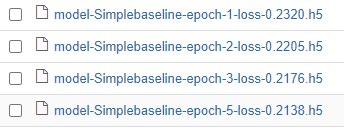

- Epoch 4 train loss 0.20718663930892944
- Epoch 4 val loss 0.21986249089241028
- Epoch 4 val loss가 Epoch 3 val loss 보다 높아서 저장이 안됐습니다.


## 추론

In [29]:
model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(best_model_file)

In [30]:

simple_model = Simplebaseline(IMAGE_SHAPE)
simple_model.load_weights(best_simple_model_file)

In [31]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [32]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()


In [33]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [34]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [35]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()


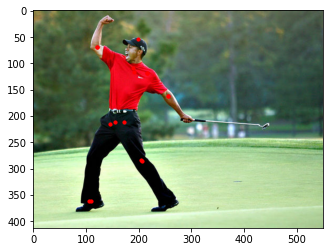

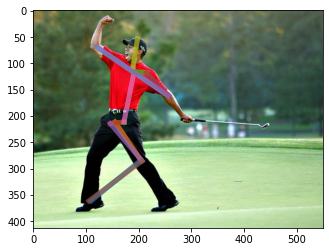

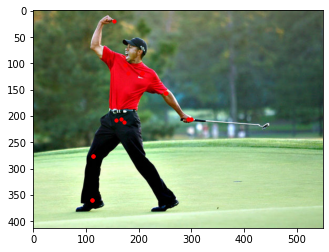

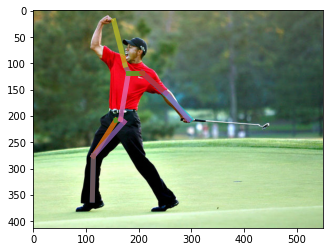

In [37]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)


image, keypoints = predict(simple_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

##### StackedHourglass 10 epoch 모델

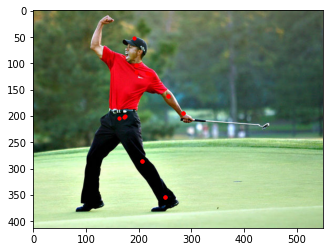

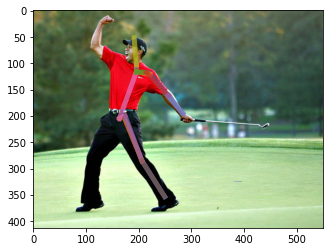

In [41]:
best_model_file = MODEL_PATH + '/model-StackedHourglass-epoch-10-loss-0.8149.h5'
epoch_10_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
epoch_10_model.load_weights(best_model_file)

image, keypoints = predict(epoch_10_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

##### 코드 변경없이 노드 그대로 학습한 모델

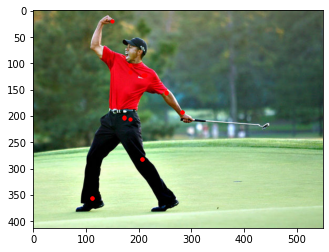

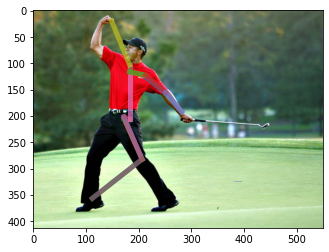

In [42]:
node_model_file = MODEL_PATH + '_a/model_SHN-epoch-5-loss-1.2217.h5'
node_model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
node_model.load_weights(node_model_file)

image, keypoints = predict(node_model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# 회고

- add 오류로 너무 많은 시간을 보냈다...
- 이걸 고치니 simplebase에서 오류가 또 발생했다...
- 무슨 이유인지는 모르겠다........
- ray는 싫다......

- 학습이 똑바로 안된다...
- loss가 계속 떨어지는 것으로 보아서 추가적으로 더 학습이 필요해보인다.